# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.all, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 53419 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.all, max_distance=1)


  0% (    1 of 53419) |            | Elapsed Time: 0:00:03 ETA:  2 days, 7:03:06

  0% (   91 of 53419) |                    | Elapsed Time: 0:00:04 ETA:  0:09:48

  0% (  176 of 53419) |                    | Elapsed Time: 0:00:05 ETA:  0:10:06

  0% (  260 of 53419) |                    | Elapsed Time: 0:00:06 ETA:  0:10:15

  0% (  343 of 53419) |                    | Elapsed Time: 0:00:07 ETA:  0:10:20

  0% (  425 of 53419) |                    | Elapsed Time: 0:00:08 ETA:  0:10:24

  0% (  489 of 53419) |                    | Elapsed Time: 0:00:09 ETA:  0:10:50

  1% (  580 of 53419) |                    | Elapsed Time: 0:00:10 ETA:  0:10:38

  1% (  668 of 53419) |                    | Elapsed Time: 0:00:11 ETA:  0:10:33

  1% (  753 of 53419) |                    | Elapsed Time: 0:00:12 ETA:  0:10:37

  1% (  843 of 53419) |                    | Elapsed Time: 0:00:13 ETA:  0:10:31

  1% (  930 of 53419) |                    | Elapsed Time: 0:00:14 ETA:  0:10:27

  1% ( 1021 of 53419) |                    | Elapsed Time: 0:00:15 ETA:  0:10:19

  2% ( 1112 of 53419) |                    | Elapsed Time: 0:00:16 ETA:  0:10:09

  2% ( 1195 of 53419) |                    | Elapsed Time: 0:00:17 ETA:  0:09:51

  2% ( 1286 of 53419) |                    | Elapsed Time: 0:00:18 ETA:  0:09:51

  2% ( 1336 of 53419) |                    | Elapsed Time: 0:00:19 ETA:  0:09:44

  2% ( 1428 of 53419) |                    | Elapsed Time: 0:00:20 ETA:  0:09:40

  2% ( 1523 of 53419) |                    | Elapsed Time: 0:00:21 ETA:  0:09:32

  3% ( 1618 of 53419) |                    | Elapsed Time: 0:00:22 ETA:  0:09:27

  3% ( 1709 of 53419) |                    | Elapsed Time: 0:00:23 ETA:  0:09:23

  3% ( 1790 of 53419) |                    | Elapsed Time: 0:00:24 ETA:  0:09:29

  3% ( 1872 of 53419) |                    | Elapsed Time: 0:00:25 ETA:  0:09:35

  3% ( 1953 of 53419) |                    | Elapsed Time: 0:00:26 ETA:  0:09:36

  3% ( 2004 of 53419) |                    | Elapsed Time: 0:00:26 ETA:  0:09:41

  3% ( 2086 of 53419) |                    | Elapsed Time: 0:00:27 ETA:  0:09:50

  4% ( 2166 of 53419) |                    | Elapsed Time: 0:00:28 ETA:  0:09:59

  4% ( 2246 of 53419) |                    | Elapsed Time: 0:00:30 ETA:  0:10:11

  4% ( 2327 of 53419) |                    | Elapsed Time: 0:00:31 ETA:  0:10:22

  4% ( 2408 of 53419) |                    | Elapsed Time: 0:00:32 ETA:  0:10:31

  4% ( 2468 of 53419) |                    | Elapsed Time: 0:00:33 ETA:  0:10:51

  4% ( 2511 of 53419) |                    | Elapsed Time: 0:00:34 ETA:  0:11:31

  4% ( 2582 of 53419) |                    | Elapsed Time: 0:00:35 ETA:  0:11:42

  5% ( 2671 of 53419) |#                   | Elapsed Time: 0:00:36 ETA:  0:11:52

  5% ( 2751 of 53419) |#                   | Elapsed Time: 0:00:37 ETA:  0:11:51

  5% ( 2830 of 53419) |#                   | Elapsed Time: 0:00:38 ETA:  0:11:51

  5% ( 2909 of 53419) |#                   | Elapsed Time: 0:00:39 ETA:  0:11:52

  5% ( 2999 of 53419) |#                   | Elapsed Time: 0:00:40 ETA:  0:11:40

  5% ( 3084 of 53419) |#                   | Elapsed Time: 0:00:41 ETA:  0:11:08

  5% ( 3163 of 53419) |#                   | Elapsed Time: 0:00:42 ETA:  0:10:28

  6% ( 3241 of 53419) |#                   | Elapsed Time: 0:00:43 ETA:  0:10:21

  6% ( 3320 of 53419) |#                   | Elapsed Time: 0:00:44 ETA:  0:10:18

  6% ( 3339 of 53419) |#                   | Elapsed Time: 0:00:44 ETA:  0:10:19

  6% ( 3422 of 53419) |#                   | Elapsed Time: 0:00:45 ETA:  0:10:14

  6% ( 3503 of 53419) |#                   | Elapsed Time: 0:00:46 ETA:  0:10:11

  6% ( 3586 of 53419) |#                   | Elapsed Time: 0:00:47 ETA:  0:10:07

  6% ( 3669 of 53419) |#                   | Elapsed Time: 0:00:48 ETA:  0:10:13

  7% ( 3754 of 53419) |#                   | Elapsed Time: 0:00:49 ETA:  0:10:12

  7% ( 3815 of 53419) |#                   | Elapsed Time: 0:00:50 ETA:  0:10:30

  7% ( 3874 of 53419) |#                   | Elapsed Time: 0:00:51 ETA:  0:10:49

  7% ( 3966 of 53419) |#                   | Elapsed Time: 0:00:52 ETA:  0:10:34

  7% ( 4007 of 53419) |#                   | Elapsed Time: 0:00:53 ETA:  0:10:34

  7% ( 4073 of 53419) |#                   | Elapsed Time: 0:00:54 ETA:  0:10:51

  7% ( 4149 of 53419) |#                   | Elapsed Time: 0:00:55 ETA:  0:10:55

  7% ( 4248 of 53419) |#                   | Elapsed Time: 0:00:56 ETA:  0:10:37

  8% ( 4334 of 53419) |#                   | Elapsed Time: 0:00:57 ETA:  0:10:33

  8% ( 4420 of 53419) |#                   | Elapsed Time: 0:00:58 ETA:  0:10:31

  8% ( 4503 of 53419) |#                   | Elapsed Time: 0:00:59 ETA:  0:10:08

  8% ( 4586 of 53419) |#                   | Elapsed Time: 0:01:00 ETA:  0:09:44

  8% ( 4675 of 53419) |#                   | Elapsed Time: 0:01:01 ETA:  0:09:45

  8% ( 4752 of 53419) |#                   | Elapsed Time: 0:01:02 ETA:  0:09:34

  9% ( 4823 of 53419) |#                   | Elapsed Time: 0:01:03 ETA:  0:09:39

  9% ( 4914 of 53419) |#                   | Elapsed Time: 0:01:04 ETA:  0:09:45

  9% ( 4997 of 53419) |#                   | Elapsed Time: 0:01:05 ETA:  0:09:47

  9% ( 5082 of 53419) |#                   | Elapsed Time: 0:01:06 ETA:  0:09:47

  9% ( 5167 of 53419) |#                   | Elapsed Time: 0:01:07 ETA:  0:09:44

  9% ( 5253 of 53419) |#                   | Elapsed Time: 0:01:08 ETA:  0:09:40

 10% ( 5342 of 53419) |##                  | Elapsed Time: 0:01:09 ETA:  0:09:40

 10% ( 5428 of 53419) |##                  | Elapsed Time: 0:01:10 ETA:  0:09:30

 10% ( 5514 of 53419) |##                  | Elapsed Time: 0:01:11 ETA:  0:09:15

 10% ( 5599 of 53419) |##                  | Elapsed Time: 0:01:12 ETA:  0:09:19

 10% ( 5684 of 53419) |##                  | Elapsed Time: 0:01:13 ETA:  0:09:16

 10% ( 5769 of 53419) |##                  | Elapsed Time: 0:01:14 ETA:  0:09:15

 10% ( 5851 of 53419) |##                  | Elapsed Time: 0:01:15 ETA:  0:09:16

 11% ( 5938 of 53419) |##                  | Elapsed Time: 0:01:16 ETA:  0:09:15

 11% ( 6010 of 53419) |##                  | Elapsed Time: 0:01:17 ETA:  0:09:13

 11% ( 6097 of 53419) |##                  | Elapsed Time: 0:01:18 ETA:  0:09:11

 11% ( 6183 of 53419) |##                  | Elapsed Time: 0:01:19 ETA:  0:09:10

 11% ( 6270 of 53419) |##                  | Elapsed Time: 0:01:20 ETA:  0:09:09

 11% ( 6356 of 53419) |##                  | Elapsed Time: 0:01:21 ETA:  0:09:07

 12% ( 6443 of 53419) |##                  | Elapsed Time: 0:01:22 ETA:  0:09:05

 12% ( 6529 of 53419) |##                  | Elapsed Time: 0:01:23 ETA:  0:09:02

 12% ( 6621 of 53419) |##                  | Elapsed Time: 0:01:24 ETA:  0:08:54

 12% ( 6678 of 53419) |##                  | Elapsed Time: 0:01:24 ETA:  0:08:51

 12% ( 6771 of 53419) |##                  | Elapsed Time: 0:01:25 ETA:  0:08:44

 12% ( 6864 of 53419) |##                  | Elapsed Time: 0:01:26 ETA:  0:08:39

 13% ( 6959 of 53419) |##                  | Elapsed Time: 0:01:27 ETA:  0:08:30

 13% ( 7055 of 53419) |##                  | Elapsed Time: 0:01:28 ETA:  0:08:22

 13% ( 7145 of 53419) |##                  | Elapsed Time: 0:01:29 ETA:  0:08:18

 13% ( 7235 of 53419) |##                  | Elapsed Time: 0:01:30 ETA:  0:08:15

 13% ( 7322 of 53419) |##                  | Elapsed Time: 0:01:31 ETA:  0:08:13

 13% ( 7346 of 53419) |##                  | Elapsed Time: 0:01:32 ETA:  0:08:13

 13% ( 7436 of 53419) |##                  | Elapsed Time: 0:01:33 ETA:  0:08:13

 14% ( 7529 of 53419) |##                  | Elapsed Time: 0:01:34 ETA:  0:08:12

 14% ( 7622 of 53419) |##                  | Elapsed Time: 0:01:35 ETA:  0:08:11

 14% ( 7714 of 53419) |##                  | Elapsed Time: 0:01:36 ETA:  0:08:12

 14% ( 7807 of 53419) |##                  | Elapsed Time: 0:01:37 ETA:  0:08:13

 14% ( 7894 of 53419) |##                  | Elapsed Time: 0:01:38 ETA:  0:08:14

 14% ( 7974 of 53419) |##                  | Elapsed Time: 0:01:39 ETA:  0:08:20

 15% ( 8013 of 53419) |###                 | Elapsed Time: 0:01:39 ETA:  0:08:21

 15% ( 8093 of 53419) |###                 | Elapsed Time: 0:01:40 ETA:  0:08:28

 15% ( 8135 of 53419) |###                 | Elapsed Time: 0:01:41 ETA:  0:09:09

 15% ( 8213 of 53419) |###                 | Elapsed Time: 0:01:42 ETA:  0:09:22

 15% ( 8291 of 53419) |###                 | Elapsed Time: 0:01:43 ETA:  0:09:35

 15% ( 8372 of 53419) |###                 | Elapsed Time: 0:01:44 ETA:  0:09:46

 15% ( 8452 of 53419) |###                 | Elapsed Time: 0:01:45 ETA:  0:09:59

 15% ( 8533 of 53419) |###                 | Elapsed Time: 0:01:46 ETA:  0:10:05

 16% ( 8616 of 53419) |###                 | Elapsed Time: 0:01:47 ETA:  0:10:01

 16% ( 8681 of 53419) |###                 | Elapsed Time: 0:01:48 ETA:  0:09:56

 16% ( 8769 of 53419) |###                 | Elapsed Time: 0:01:49 ETA:  0:09:46

 16% ( 8859 of 53419) |###                 | Elapsed Time: 0:01:50 ETA:  0:09:00

 16% ( 8946 of 53419) |###                 | Elapsed Time: 0:01:51 ETA:  0:08:51

 16% ( 9034 of 53419) |###                 | Elapsed Time: 0:01:52 ETA:  0:08:42

 17% ( 9123 of 53419) |###                 | Elapsed Time: 0:01:53 ETA:  0:08:34

 17% ( 9212 of 53419) |###                 | Elapsed Time: 0:01:54 ETA:  0:08:25

 17% ( 9301 of 53419) |###                 | Elapsed Time: 0:01:55 ETA:  0:08:17

 17% ( 9349 of 53419) |###                 | Elapsed Time: 0:01:56 ETA:  0:08:13

 17% ( 9437 of 53419) |###                 | Elapsed Time: 0:01:57 ETA:  0:08:10

 17% ( 9524 of 53419) |###                 | Elapsed Time: 0:01:58 ETA:  0:08:09

 17% ( 9610 of 53419) |###                 | Elapsed Time: 0:01:59 ETA:  0:08:11

 18% ( 9699 of 53419) |###                 | Elapsed Time: 0:02:00 ETA:  0:08:08

 18% ( 9786 of 53419) |###                 | Elapsed Time: 0:02:01 ETA:  0:08:08

 18% ( 9875 of 53419) |###                 | Elapsed Time: 0:02:02 ETA:  0:08:07

 18% ( 9965 of 53419) |###                 | Elapsed Time: 0:02:03 ETA:  0:08:05

 18% (10017 of 53419) |###                 | Elapsed Time: 0:02:03 ETA:  0:08:06

 18% (10105 of 53419) |###                 | Elapsed Time: 0:02:04 ETA:  0:08:04

 19% (10191 of 53419) |###                 | Elapsed Time: 0:02:05 ETA:  0:08:05

 19% (10281 of 53419) |###                 | Elapsed Time: 0:02:06 ETA:  0:08:02

 19% (10371 of 53419) |###                 | Elapsed Time: 0:02:07 ETA:  0:07:58

 19% (10459 of 53419) |###                 | Elapsed Time: 0:02:08 ETA:  0:07:58

 19% (10549 of 53419) |###                 | Elapsed Time: 0:02:09 ETA:  0:07:55

 19% (10638 of 53419) |###                 | Elapsed Time: 0:02:10 ETA:  0:07:54

 20% (10684 of 53419) |####                | Elapsed Time: 0:02:11 ETA:  0:07:54

 20% (10774 of 53419) |####                | Elapsed Time: 0:02:12 ETA:  0:07:51

 20% (10864 of 53419) |####                | Elapsed Time: 0:02:13 ETA:  0:07:48

 20% (10950 of 53419) |####                | Elapsed Time: 0:02:14 ETA:  0:07:47

 20% (11038 of 53419) |####                | Elapsed Time: 0:02:15 ETA:  0:07:48

 20% (11125 of 53419) |####                | Elapsed Time: 0:02:16 ETA:  0:07:49

 20% (11212 of 53419) |####                | Elapsed Time: 0:02:17 ETA:  0:07:49

 21% (11306 of 53419) |####                | Elapsed Time: 0:02:18 ETA:  0:07:45

 21% (11352 of 53419) |####                | Elapsed Time: 0:02:18 ETA:  0:07:44

 21% (11440 of 53419) |####                | Elapsed Time: 0:02:19 ETA:  0:07:44

 21% (11531 of 53419) |####                | Elapsed Time: 0:02:20 ETA:  0:07:43

 21% (11622 of 53419) |####                | Elapsed Time: 0:02:21 ETA:  0:07:41

 21% (11713 of 53419) |####                | Elapsed Time: 0:02:22 ETA:  0:07:36

 22% (11802 of 53419) |####                | Elapsed Time: 0:02:23 ETA:  0:07:33

 22% (11892 of 53419) |####                | Elapsed Time: 0:02:24 ETA:  0:07:30

 22% (11977 of 53419) |####                | Elapsed Time: 0:02:25 ETA:  0:07:30

 22% (12020 of 53419) |####                | Elapsed Time: 0:02:26 ETA:  0:07:32

 22% (12088 of 53419) |####                | Elapsed Time: 0:02:27 ETA:  0:07:49

 22% (12116 of 53419) |####                | Elapsed Time: 0:02:28 ETA:  0:08:43

 22% (12180 of 53419) |####                | Elapsed Time: 0:02:29 ETA:  0:09:10

 22% (12242 of 53419) |####                | Elapsed Time: 0:02:30 ETA:  0:09:42

 23% (12305 of 53419) |####                | Elapsed Time: 0:02:31 ETA:  0:10:15

 23% (12368 of 53419) |####                | Elapsed Time: 0:02:32 ETA:  0:10:50

 23% (12430 of 53419) |####                | Elapsed Time: 0:02:33 ETA:  0:11:32

 23% (12497 of 53419) |####                | Elapsed Time: 0:02:34 ETA:  0:12:01

 23% (12568 of 53419) |####                | Elapsed Time: 0:02:35 ETA:  0:12:08

 23% (12640 of 53419) |####                | Elapsed Time: 0:02:36 ETA:  0:12:00

 23% (12688 of 53419) |####                | Elapsed Time: 0:02:37 ETA:  0:11:00

 23% (12782 of 53419) |####                | Elapsed Time: 0:02:38 ETA:  0:10:19

 24% (12855 of 53419) |####                | Elapsed Time: 0:02:39 ETA:  0:10:04

 24% (12938 of 53419) |####                | Elapsed Time: 0:02:40 ETA:  0:09:39

 24% (13019 of 53419) |####                | Elapsed Time: 0:02:41 ETA:  0:09:17

 24% (13104 of 53419) |####                | Elapsed Time: 0:02:42 ETA:  0:08:52

 24% (13187 of 53419) |####                | Elapsed Time: 0:02:43 ETA:  0:08:34

 24% (13273 of 53419) |####                | Elapsed Time: 0:02:44 ETA:  0:08:19

 25% (13355 of 53419) |#####               | Elapsed Time: 0:02:45 ETA:  0:08:06

 25% (13441 of 53419) |#####               | Elapsed Time: 0:02:46 ETA:  0:07:53

 25% (13527 of 53419) |#####               | Elapsed Time: 0:02:47 ETA:  0:07:59

 25% (13614 of 53419) |#####               | Elapsed Time: 0:02:48 ETA:  0:07:46

 25% (13701 of 53419) |#####               | Elapsed Time: 0:02:49 ETA:  0:07:42

 25% (13786 of 53419) |#####               | Elapsed Time: 0:02:50 ETA:  0:07:38

 25% (13861 of 53419) |#####               | Elapsed Time: 0:02:51 ETA:  0:07:45

 26% (13937 of 53419) |#####               | Elapsed Time: 0:02:52 ETA:  0:07:49

 26% (14023 of 53419) |#####               | Elapsed Time: 0:02:53 ETA:  0:07:56

 26% (14121 of 53419) |#####               | Elapsed Time: 0:02:54 ETA:  0:07:44

 26% (14204 of 53419) |#####               | Elapsed Time: 0:02:55 ETA:  0:07:46

 26% (14280 of 53419) |#####               | Elapsed Time: 0:02:56 ETA:  0:07:55

 26% (14369 of 53419) |#####               | Elapsed Time: 0:02:57 ETA:  0:07:51

 27% (14456 of 53419) |#####               | Elapsed Time: 0:02:58 ETA:  0:07:48

 27% (14542 of 53419) |#####               | Elapsed Time: 0:02:59 ETA:  0:07:37

 27% (14619 of 53419) |#####               | Elapsed Time: 0:03:00 ETA:  0:07:36

 27% (14691 of 53419) |#####               | Elapsed Time: 0:03:01 ETA:  0:07:40

 27% (14782 of 53419) |#####               | Elapsed Time: 0:03:02 ETA:  0:07:34

 27% (14859 of 53419) |#####               | Elapsed Time: 0:03:03 ETA:  0:07:50

 27% (14932 of 53419) |#####               | Elapsed Time: 0:03:04 ETA:  0:07:59

 28% (15016 of 53419) |#####               | Elapsed Time: 0:03:05 ETA:  0:07:51

 28% (15109 of 53419) |#####               | Elapsed Time: 0:03:06 ETA:  0:07:46

 28% (15204 of 53419) |#####               | Elapsed Time: 0:03:07 ETA:  0:07:39

 28% (15296 of 53419) |#####               | Elapsed Time: 0:03:08 ETA:  0:07:32

 28% (15358 of 53419) |#####               | Elapsed Time: 0:03:09 ETA:  0:07:26

 28% (15441 of 53419) |#####               | Elapsed Time: 0:03:10 ETA:  0:07:16

 29% (15533 of 53419) |#####               | Elapsed Time: 0:03:11 ETA:  0:07:14

 29% (15623 of 53419) |#####               | Elapsed Time: 0:03:12 ETA:  0:07:03

 29% (15692 of 53419) |#####               | Elapsed Time: 0:03:13 ETA:  0:07:06

 29% (15763 of 53419) |#####               | Elapsed Time: 0:03:14 ETA:  0:07:15

 29% (15835 of 53419) |#####               | Elapsed Time: 0:03:15 ETA:  0:07:34

 29% (15905 of 53419) |#####               | Elapsed Time: 0:03:16 ETA:  0:07:55

 29% (15988 of 53419) |#####               | Elapsed Time: 0:03:17 ETA:  0:08:04

 30% (16026 of 53419) |######              | Elapsed Time: 0:03:17 ETA:  0:08:04

 30% (16121 of 53419) |######              | Elapsed Time: 0:03:18 ETA:  0:07:51

 30% (16214 of 53419) |######              | Elapsed Time: 0:03:19 ETA:  0:07:49

 30% (16310 of 53419) |######              | Elapsed Time: 0:03:20 ETA:  0:07:42

 30% (16400 of 53419) |######              | Elapsed Time: 0:03:21 ETA:  0:07:21

 30% (16493 of 53419) |######              | Elapsed Time: 0:03:23 ETA:  0:07:42

 31% (16590 of 53419) |######              | Elapsed Time: 0:03:24 ETA:  0:07:18

 31% (16694 of 53419) |######              | Elapsed Time: 0:03:25 ETA:  0:06:57

 31% (16779 of 53419) |######              | Elapsed Time: 0:03:26 ETA:  0:06:56

 31% (16868 of 53419) |######              | Elapsed Time: 0:03:27 ETA:  0:07:00

 31% (16952 of 53419) |######              | Elapsed Time: 0:03:28 ETA:  0:07:06

 31% (17031 of 53419) |######              | Elapsed Time: 0:03:29 ETA:  0:07:20

 32% (17116 of 53419) |######              | Elapsed Time: 0:03:30 ETA:  0:07:23

 32% (17196 of 53419) |######              | Elapsed Time: 0:03:31 ETA:  0:06:51

 32% (17284 of 53419) |######              | Elapsed Time: 0:03:32 ETA:  0:06:58

 32% (17362 of 53419) |######              | Elapsed Time: 0:03:33 ETA:  0:06:59

 32% (17451 of 53419) |######              | Elapsed Time: 0:03:34 ETA:  0:06:59

 32% (17529 of 53419) |######              | Elapsed Time: 0:03:35 ETA:  0:07:04

 32% (17603 of 53419) |######              | Elapsed Time: 0:03:36 ETA:  0:07:16

 33% (17676 of 53419) |######              | Elapsed Time: 0:03:37 ETA:  0:07:25

 33% (17775 of 53419) |######              | Elapsed Time: 0:03:38 ETA:  0:07:07

 33% (17852 of 53419) |######              | Elapsed Time: 0:03:39 ETA:  0:07:12

 33% (17932 of 53419) |######              | Elapsed Time: 0:03:40 ETA:  0:07:11

 33% (18029 of 53419) |######              | Elapsed Time: 0:03:41 ETA:  0:07:09

 33% (18113 of 53419) |######              | Elapsed Time: 0:03:42 ETA:  0:07:13

 34% (18206 of 53419) |######              | Elapsed Time: 0:03:43 ETA:  0:06:58

 34% (18297 of 53419) |######              | Elapsed Time: 0:03:44 ETA:  0:06:41

 34% (18388 of 53419) |######              | Elapsed Time: 0:03:45 ETA:  0:06:23

 34% (18481 of 53419) |######              | Elapsed Time: 0:03:46 ETA:  0:06:28

 34% (18576 of 53419) |######              | Elapsed Time: 0:03:47 ETA:  0:06:12

 34% (18671 of 53419) |######              | Elapsed Time: 0:03:48 ETA:  0:05:59

 35% (18697 of 53419) |#######             | Elapsed Time: 0:03:48 ETA:  0:05:55

 35% (18792 of 53419) |#######             | Elapsed Time: 0:03:49 ETA:  0:05:52

 35% (18890 of 53419) |#######             | Elapsed Time: 0:03:50 ETA:  0:05:41

 35% (18978 of 53419) |#######             | Elapsed Time: 0:03:51 ETA:  0:05:43

 35% (19041 of 53419) |#######             | Elapsed Time: 0:03:52 ETA:  0:06:03

 35% (19094 of 53419) |#######             | Elapsed Time: 0:03:53 ETA:  0:06:35

 35% (19161 of 53419) |#######             | Elapsed Time: 0:03:54 ETA:  0:06:58

 36% (19233 of 53419) |#######             | Elapsed Time: 0:03:55 ETA:  0:07:20

 36% (19294 of 53419) |#######             | Elapsed Time: 0:03:56 ETA:  0:07:56

 36% (19365 of 53419) |#######             | Elapsed Time: 0:03:57 ETA:  0:08:05

 36% (19454 of 53419) |#######             | Elapsed Time: 0:03:58 ETA:  0:08:12

 36% (19545 of 53419) |#######             | Elapsed Time: 0:03:59 ETA:  0:08:19

 36% (19620 of 53419) |#######             | Elapsed Time: 0:04:00 ETA:  0:08:33

 36% (19705 of 53419) |#######             | Elapsed Time: 0:04:01 ETA:  0:08:08

 37% (19773 of 53419) |#######             | Elapsed Time: 0:04:02 ETA:  0:07:50

 37% (19838 of 53419) |#######             | Elapsed Time: 0:04:03 ETA:  0:07:50

 37% (19923 of 53419) |#######             | Elapsed Time: 0:04:04 ETA:  0:07:36

 37% (20017 of 53419) |#######             | Elapsed Time: 0:04:05 ETA:  0:07:03

 37% (20033 of 53419) |#######             | Elapsed Time: 0:04:06 ETA:  0:06:54

 37% (20107 of 53419) |#######             | Elapsed Time: 0:04:07 ETA:  0:07:07

 37% (20181 of 53419) |#######             | Elapsed Time: 0:04:08 ETA:  0:07:24

 37% (20269 of 53419) |#######             | Elapsed Time: 0:04:09 ETA:  0:07:09

 38% (20356 of 53419) |#######             | Elapsed Time: 0:04:10 ETA:  0:07:06

 38% (20420 of 53419) |#######             | Elapsed Time: 0:04:11 ETA:  0:07:10

 38% (20484 of 53419) |#######             | Elapsed Time: 0:04:12 ETA:  0:07:10

 38% (20550 of 53419) |#######             | Elapsed Time: 0:04:13 ETA:  0:07:30

 38% (20626 of 53419) |#######             | Elapsed Time: 0:04:14 ETA:  0:07:49

 38% (20700 of 53419) |#######             | Elapsed Time: 0:04:14 ETA:  0:07:28

 38% (20791 of 53419) |#######             | Elapsed Time: 0:04:15 ETA:  0:07:10

 39% (20873 of 53419) |#######             | Elapsed Time: 0:04:16 ETA:  0:07:01

 39% (20959 of 53419) |#######             | Elapsed Time: 0:04:17 ETA:  0:07:02

 39% (21043 of 53419) |#######             | Elapsed Time: 0:04:18 ETA:  0:07:04

 39% (21127 of 53419) |#######             | Elapsed Time: 0:04:19 ETA:  0:06:44

 39% (21211 of 53419) |#######             | Elapsed Time: 0:04:20 ETA:  0:06:24

 39% (21296 of 53419) |#######             | Elapsed Time: 0:04:21 ETA:  0:06:08

 40% (21368 of 53419) |########            | Elapsed Time: 0:04:22 ETA:  0:06:07

 40% (21456 of 53419) |########            | Elapsed Time: 0:04:23 ETA:  0:06:13

 40% (21539 of 53419) |########            | Elapsed Time: 0:04:24 ETA:  0:06:20

 40% (21614 of 53419) |########            | Elapsed Time: 0:04:25 ETA:  0:06:25

 40% (21692 of 53419) |########            | Elapsed Time: 0:04:26 ETA:  0:06:31

 40% (21746 of 53419) |########            | Elapsed Time: 0:04:28 ETA:  0:07:33

 40% (21823 of 53419) |########            | Elapsed Time: 0:04:29 ETA:  0:07:39

 41% (21904 of 53419) |########            | Elapsed Time: 0:04:30 ETA:  0:07:41

 41% (21977 of 53419) |########            | Elapsed Time: 0:04:31 ETA:  0:07:53

 41% (22036 of 53419) |########            | Elapsed Time: 0:04:32 ETA:  0:07:53

 41% (22110 of 53419) |########            | Elapsed Time: 0:04:33 ETA:  0:08:07

 41% (22205 of 53419) |########            | Elapsed Time: 0:04:34 ETA:  0:07:52

 41% (22312 of 53419) |########            | Elapsed Time: 0:04:35 ETA:  0:07:17

 41% (22399 of 53419) |########            | Elapsed Time: 0:04:36 ETA:  0:07:07

 42% (22485 of 53419) |########            | Elapsed Time: 0:04:37 ETA:  0:06:02

 42% (22572 of 53419) |########            | Elapsed Time: 0:04:38 ETA:  0:05:52

 42% (22635 of 53419) |########            | Elapsed Time: 0:04:39 ETA:  0:06:06

 42% (22704 of 53419) |########            | Elapsed Time: 0:04:40 ETA:  0:06:09

 42% (22772 of 53419) |########            | Elapsed Time: 0:04:41 ETA:  0:06:16

 42% (22843 of 53419) |########            | Elapsed Time: 0:04:42 ETA:  0:06:18

 42% (22932 of 53419) |########            | Elapsed Time: 0:04:43 ETA:  0:06:23

 43% (23024 of 53419) |########            | Elapsed Time: 0:04:44 ETA:  0:06:36

 43% (23124 of 53419) |########            | Elapsed Time: 0:04:45 ETA:  0:06:23

 43% (23226 of 53419) |########            | Elapsed Time: 0:04:46 ETA:  0:06:07

 43% (23330 of 53419) |########            | Elapsed Time: 0:04:47 ETA:  0:05:51

 43% (23371 of 53419) |########            | Elapsed Time: 0:04:47 ETA:  0:05:31

 43% (23449 of 53419) |########            | Elapsed Time: 0:04:48 ETA:  0:05:22

 44% (23529 of 53419) |########            | Elapsed Time: 0:04:49 ETA:  0:05:11

 44% (23611 of 53419) |########            | Elapsed Time: 0:04:50 ETA:  0:05:01

 44% (23703 of 53419) |########            | Elapsed Time: 0:04:51 ETA:  0:04:58

 44% (23785 of 53419) |########            | Elapsed Time: 0:04:52 ETA:  0:05:04

 44% (23878 of 53419) |########            | Elapsed Time: 0:04:53 ETA:  0:05:08

 44% (23968 of 53419) |########            | Elapsed Time: 0:04:54 ETA:  0:05:18

 45% (24039 of 53419) |#########           | Elapsed Time: 0:04:56 ETA:  0:06:03

 45% (24109 of 53419) |#########           | Elapsed Time: 0:04:57 ETA:  0:06:11

 45% (24190 of 53419) |#########           | Elapsed Time: 0:04:58 ETA:  0:06:08

 45% (24270 of 53419) |#########           | Elapsed Time: 0:04:59 ETA:  0:06:09

 45% (24355 of 53419) |#########           | Elapsed Time: 0:05:00 ETA:  0:06:15

 45% (24443 of 53419) |#########           | Elapsed Time: 0:05:01 ETA:  0:06:08

 45% (24530 of 53419) |#########           | Elapsed Time: 0:05:02 ETA:  0:06:14

 46% (24615 of 53419) |#########           | Elapsed Time: 0:05:03 ETA:  0:06:17

 46% (24707 of 53419) |#########           | Elapsed Time: 0:05:04 ETA:  0:05:54

 46% (24772 of 53419) |#########           | Elapsed Time: 0:05:05 ETA:  0:05:58

 46% (24859 of 53419) |#########           | Elapsed Time: 0:05:06 ETA:  0:05:51

 46% (24946 of 53419) |#########           | Elapsed Time: 0:05:07 ETA:  0:05:44

 46% (25018 of 53419) |#########           | Elapsed Time: 0:05:08 ETA:  0:05:55

 46% (25099 of 53419) |#########           | Elapsed Time: 0:05:09 ETA:  0:06:01

 47% (25185 of 53419) |#########           | Elapsed Time: 0:05:10 ETA:  0:06:01

 47% (25272 of 53419) |#########           | Elapsed Time: 0:05:11 ETA:  0:05:58

 47% (25375 of 53419) |#########           | Elapsed Time: 0:05:12 ETA:  0:05:47

 47% (25459 of 53419) |#########           | Elapsed Time: 0:05:13 ETA:  0:05:27

 47% (25545 of 53419) |#########           | Elapsed Time: 0:05:14 ETA:  0:05:27

 47% (25640 of 53419) |#########           | Elapsed Time: 0:05:15 ETA:  0:05:18

 48% (25697 of 53419) |#########           | Elapsed Time: 0:05:16 ETA:  0:05:31

 48% (25745 of 53419) |#########           | Elapsed Time: 0:05:17 ETA:  0:06:05

 48% (25839 of 53419) |#########           | Elapsed Time: 0:05:18 ETA:  0:05:55

 48% (25930 of 53419) |#########           | Elapsed Time: 0:05:19 ETA:  0:05:50

 48% (26020 of 53419) |#########           | Elapsed Time: 0:05:20 ETA:  0:05:45

 48% (26042 of 53419) |#########           | Elapsed Time: 0:05:20 ETA:  0:05:44

 48% (26117 of 53419) |#########           | Elapsed Time: 0:05:21 ETA:  0:05:53

 48% (26175 of 53419) |#########           | Elapsed Time: 0:05:22 ETA:  0:06:24

 49% (26215 of 53419) |#########           | Elapsed Time: 0:05:23 ETA:  0:07:30

 49% (26262 of 53419) |#########           | Elapsed Time: 0:05:24 ETA:  0:07:43

 49% (26325 of 53419) |#########           | Elapsed Time: 0:05:25 ETA:  0:07:20

 49% (26417 of 53419) |#########           | Elapsed Time: 0:05:26 ETA:  0:07:22

 49% (26481 of 53419) |#########           | Elapsed Time: 0:05:27 ETA:  0:07:59

 49% (26539 of 53419) |#########           | Elapsed Time: 0:05:28 ETA:  0:08:48

 49% (26612 of 53419) |#########           | Elapsed Time: 0:05:29 ETA:  0:08:41

 49% (26693 of 53419) |#########           | Elapsed Time: 0:05:30 ETA:  0:08:31

 50% (26710 of 53419) |##########          | Elapsed Time: 0:05:31 ETA:  0:08:15

 50% (26789 of 53419) |##########          | Elapsed Time: 0:05:32 ETA:  0:07:18

 50% (26868 of 53419) |##########          | Elapsed Time: 0:05:33 ETA:  0:06:37

 50% (26948 of 53419) |##########          | Elapsed Time: 0:05:34 ETA:  0:06:16

 50% (27022 of 53419) |##########          | Elapsed Time: 0:05:35 ETA:  0:06:36

 50% (27089 of 53419) |##########          | Elapsed Time: 0:05:36 ETA:  0:06:31

 50% (27164 of 53419) |##########          | Elapsed Time: 0:05:37 ETA:  0:06:10

 51% (27259 of 53419) |##########          | Elapsed Time: 0:05:38 ETA:  0:05:45

 51% (27355 of 53419) |##########          | Elapsed Time: 0:05:39 ETA:  0:05:28

 51% (27378 of 53419) |##########          | Elapsed Time: 0:05:39 ETA:  0:05:24

 51% (27473 of 53419) |##########          | Elapsed Time: 0:05:40 ETA:  0:05:07

 51% (27569 of 53419) |##########          | Elapsed Time: 0:05:41 ETA:  0:04:50

 51% (27663 of 53419) |##########          | Elapsed Time: 0:05:42 ETA:  0:04:37

 51% (27756 of 53419) |##########          | Elapsed Time: 0:05:43 ETA:  0:04:19

 52% (27847 of 53419) |##########          | Elapsed Time: 0:05:44 ETA:  0:03:59

 52% (27935 of 53419) |##########          | Elapsed Time: 0:05:45 ETA:  0:03:48

 52% (28045 of 53419) |##########          | Elapsed Time: 0:05:46 ETA:  0:03:39

 52% (28136 of 53419) |##########          | Elapsed Time: 0:05:47 ETA:  0:03:41

 52% (28229 of 53419) |##########          | Elapsed Time: 0:05:48 ETA:  0:03:41

 53% (28324 of 53419) |##########          | Elapsed Time: 0:05:49 ETA:  0:03:41

 53% (28347 of 53419) |##########          | Elapsed Time: 0:05:50 ETA:  0:05:04

 53% (28422 of 53419) |##########          | Elapsed Time: 0:05:51 ETA:  0:05:21

 53% (28517 of 53419) |##########          | Elapsed Time: 0:05:52 ETA:  0:05:16

 53% (28611 of 53419) |##########          | Elapsed Time: 0:05:53 ETA:  0:05:09

 53% (28713 of 53419) |##########          | Elapsed Time: 0:05:54 ETA:  0:05:15

 53% (28813 of 53419) |##########          | Elapsed Time: 0:05:55 ETA:  0:05:05

 54% (28901 of 53419) |##########          | Elapsed Time: 0:05:56 ETA:  0:05:09

 54% (28988 of 53419) |##########          | Elapsed Time: 0:05:57 ETA:  0:05:16

 54% (29065 of 53419) |##########          | Elapsed Time: 0:05:58 ETA:  0:04:00

 54% (29138 of 53419) |##########          | Elapsed Time: 0:05:59 ETA:  0:04:01

 54% (29229 of 53419) |##########          | Elapsed Time: 0:06:00 ETA:  0:04:03

 54% (29299 of 53419) |##########          | Elapsed Time: 0:06:01 ETA:  0:04:23

 55% (29381 of 53419) |###########         | Elapsed Time: 0:06:02 ETA:  0:04:31

 55% (29474 of 53419) |###########         | Elapsed Time: 0:06:03 ETA:  0:04:23

 55% (29569 of 53419) |###########         | Elapsed Time: 0:06:04 ETA:  0:04:26

 55% (29642 of 53419) |###########         | Elapsed Time: 0:06:05 ETA:  0:04:38

 55% (29699 of 53419) |###########         | Elapsed Time: 0:06:06 ETA:  0:05:05

 55% (29771 of 53419) |###########         | Elapsed Time: 0:06:07 ETA:  0:05:08

 55% (29849 of 53419) |###########         | Elapsed Time: 0:06:08 ETA:  0:05:03

 56% (29937 of 53419) |###########         | Elapsed Time: 0:06:09 ETA:  0:05:05

 56% (30026 of 53419) |###########         | Elapsed Time: 0:06:10 ETA:  0:04:47

 56% (30049 of 53419) |###########         | Elapsed Time: 0:06:11 ETA:  0:04:50

 56% (30152 of 53419) |###########         | Elapsed Time: 0:06:12 ETA:  0:04:39

 56% (30228 of 53419) |###########         | Elapsed Time: 0:06:13 ETA:  0:04:57

 56% (30304 of 53419) |###########         | Elapsed Time: 0:06:14 ETA:  0:04:53

 56% (30386 of 53419) |###########         | Elapsed Time: 0:06:15 ETA:  0:04:26

 57% (30471 of 53419) |###########         | Elapsed Time: 0:06:16 ETA:  0:04:14

 57% (30559 of 53419) |###########         | Elapsed Time: 0:06:17 ETA:  0:04:04

 57% (30646 of 53419) |###########         | Elapsed Time: 0:06:18 ETA:  0:04:03

 57% (30716 of 53419) |###########         | Elapsed Time: 0:06:18 ETA:  0:04:07

 57% (30797 of 53419) |###########         | Elapsed Time: 0:06:20 ETA:  0:04:14

 57% (30896 of 53419) |###########         | Elapsed Time: 0:06:21 ETA:  0:04:17

 58% (30985 of 53419) |###########         | Elapsed Time: 0:06:22 ETA:  0:04:05

 58% (31082 of 53419) |###########         | Elapsed Time: 0:06:23 ETA:  0:03:47

 58% (31183 of 53419) |###########         | Elapsed Time: 0:06:24 ETA:  0:03:33

 58% (31275 of 53419) |###########         | Elapsed Time: 0:06:25 ETA:  0:03:26

 58% (31352 of 53419) |###########         | Elapsed Time: 0:06:26 ETA:  0:03:33

 58% (31384 of 53419) |###########         | Elapsed Time: 0:06:26 ETA:  0:03:36

 58% (31479 of 53419) |###########         | Elapsed Time: 0:06:27 ETA:  0:03:26

 59% (31571 of 53419) |###########         | Elapsed Time: 0:06:28 ETA:  0:03:16

 59% (31667 of 53419) |###########         | Elapsed Time: 0:06:29 ETA:  0:03:17

 59% (31758 of 53419) |###########         | Elapsed Time: 0:06:30 ETA:  0:03:14

 59% (31845 of 53419) |###########         | Elapsed Time: 0:06:31 ETA:  0:03:21

 59% (31925 of 53419) |###########         | Elapsed Time: 0:06:32 ETA:  0:03:37

 59% (32007 of 53419) |###########         | Elapsed Time: 0:06:33 ETA:  0:03:44

 60% (32052 of 53419) |############        | Elapsed Time: 0:06:33 ETA:  0:03:28

 60% (32137 of 53419) |############        | Elapsed Time: 0:06:34 ETA:  0:03:25

 60% (32224 of 53419) |############        | Elapsed Time: 0:06:35 ETA:  0:03:31

 60% (32306 of 53419) |############        | Elapsed Time: 0:06:36 ETA:  0:03:39

 60% (32401 of 53419) |############        | Elapsed Time: 0:06:37 ETA:  0:03:40

 60% (32489 of 53419) |############        | Elapsed Time: 0:06:38 ETA:  0:03:41

 61% (32594 of 53419) |############        | Elapsed Time: 0:06:39 ETA:  0:03:25

 61% (32685 of 53419) |############        | Elapsed Time: 0:06:40 ETA:  0:03:15

 61% (32720 of 53419) |############        | Elapsed Time: 0:06:41 ETA:  0:03:08

 61% (32810 of 53419) |############        | Elapsed Time: 0:06:42 ETA:  0:03:13

 61% (32905 of 53419) |############        | Elapsed Time: 0:06:43 ETA:  0:03:04

 61% (32999 of 53419) |############        | Elapsed Time: 0:06:44 ETA:  0:02:56

 61% (33094 of 53419) |############        | Elapsed Time: 0:06:45 ETA:  0:02:45

 62% (33163 of 53419) |############        | Elapsed Time: 0:06:46 ETA:  0:03:04

 62% (33235 of 53419) |############        | Elapsed Time: 0:06:47 ETA:  0:03:16

 62% (33318 of 53419) |############        | Elapsed Time: 0:06:48 ETA:  0:03:34

 62% (33387 of 53419) |############        | Elapsed Time: 0:06:49 ETA:  0:03:38

 62% (33459 of 53419) |############        | Elapsed Time: 0:06:50 ETA:  0:03:49

 62% (33552 of 53419) |############        | Elapsed Time: 0:06:51 ETA:  0:03:46

 62% (33645 of 53419) |############        | Elapsed Time: 0:06:52 ETA:  0:03:47

 63% (33745 of 53419) |############        | Elapsed Time: 0:06:53 ETA:  0:03:41

 63% (33839 of 53419) |############        | Elapsed Time: 0:06:54 ETA:  0:03:41

 63% (33924 of 53419) |############        | Elapsed Time: 0:06:55 ETA:  0:03:27

 63% (33987 of 53419) |############        | Elapsed Time: 0:06:56 ETA:  0:03:33

 63% (34055 of 53419) |############        | Elapsed Time: 0:06:57 ETA:  0:03:33

 63% (34156 of 53419) |############        | Elapsed Time: 0:06:58 ETA:  0:03:19

 64% (34242 of 53419) |############        | Elapsed Time: 0:06:59 ETA:  0:03:07

 64% (34327 of 53419) |############        | Elapsed Time: 0:07:00 ETA:  0:03:12

 64% (34408 of 53419) |############        | Elapsed Time: 0:07:01 ETA:  0:03:21

 64% (34505 of 53419) |############        | Elapsed Time: 0:07:02 ETA:  0:03:22

 64% (34586 of 53419) |############        | Elapsed Time: 0:07:03 ETA:  0:03:31

 64% (34677 of 53419) |############        | Elapsed Time: 0:07:04 ETA:  0:03:25

 65% (34723 of 53419) |#############       | Elapsed Time: 0:07:04 ETA:  0:03:04

 65% (34804 of 53419) |#############       | Elapsed Time: 0:07:05 ETA:  0:03:04

 65% (34881 of 53419) |#############       | Elapsed Time: 0:07:06 ETA:  0:03:23

 65% (34969 of 53419) |#############       | Elapsed Time: 0:07:07 ETA:  0:03:21

 65% (35064 of 53419) |#############       | Elapsed Time: 0:07:08 ETA:  0:03:11

 65% (35152 of 53419) |#############       | Elapsed Time: 0:07:09 ETA:  0:03:04

 65% (35243 of 53419) |#############       | Elapsed Time: 0:07:10 ETA:  0:03:08

 66% (35340 of 53419) |#############       | Elapsed Time: 0:07:11 ETA:  0:02:54

 66% (35391 of 53419) |#############       | Elapsed Time: 0:07:12 ETA:  0:02:53

 66% (35482 of 53419) |#############       | Elapsed Time: 0:07:13 ETA:  0:02:51

 66% (35586 of 53419) |#############       | Elapsed Time: 0:07:14 ETA:  0:02:32

 66% (35688 of 53419) |#############       | Elapsed Time: 0:07:15 ETA:  0:02:12

 66% (35775 of 53419) |#############       | Elapsed Time: 0:07:16 ETA:  0:02:12

 67% (35861 of 53419) |#############       | Elapsed Time: 0:07:17 ETA:  0:02:18

 67% (35946 of 53419) |#############       | Elapsed Time: 0:07:18 ETA:  0:02:18

 67% (36033 of 53419) |#############       | Elapsed Time: 0:07:19 ETA:  0:02:20

 67% (36058 of 53419) |#############       | Elapsed Time: 0:07:19 ETA:  0:02:21

 67% (36158 of 53419) |#############       | Elapsed Time: 0:07:20 ETA:  0:02:15

 67% (36252 of 53419) |#############       | Elapsed Time: 0:07:21 ETA:  0:02:12

 68% (36331 of 53419) |#############       | Elapsed Time: 0:07:22 ETA:  0:02:30

 68% (36386 of 53419) |#############       | Elapsed Time: 0:07:24 ETA:  0:04:22

 68% (36475 of 53419) |#############       | Elapsed Time: 0:07:25 ETA:  0:04:19

 68% (36557 of 53419) |#############       | Elapsed Time: 0:07:26 ETA:  0:04:22

 68% (36645 of 53419) |#############       | Elapsed Time: 0:07:27 ETA:  0:04:17

 68% (36726 of 53419) |#############       | Elapsed Time: 0:07:28 ETA:  0:04:13

 68% (36813 of 53419) |#############       | Elapsed Time: 0:07:29 ETA:  0:04:09

 69% (36911 of 53419) |#############       | Elapsed Time: 0:07:30 ETA:  0:04:10

 69% (37007 of 53419) |#############       | Elapsed Time: 0:07:31 ETA:  0:04:07

 69% (37095 of 53419) |#############       | Elapsed Time: 0:07:32 ETA:  0:03:57

 69% (37186 of 53419) |#############       | Elapsed Time: 0:07:33 ETA:  0:02:22

 69% (37281 of 53419) |#############       | Elapsed Time: 0:07:34 ETA:  0:02:16

 69% (37370 of 53419) |#############       | Elapsed Time: 0:07:35 ETA:  0:02:11

 70% (37394 of 53419) |##############      | Elapsed Time: 0:07:35 ETA:  0:02:20

 70% (37473 of 53419) |##############      | Elapsed Time: 0:07:36 ETA:  0:02:30

 70% (37552 of 53419) |##############      | Elapsed Time: 0:07:37 ETA:  0:02:36

 70% (37658 of 53419) |##############      | Elapsed Time: 0:07:38 ETA:  0:02:28

 70% (37749 of 53419) |##############      | Elapsed Time: 0:07:39 ETA:  0:02:31

 70% (37845 of 53419) |##############      | Elapsed Time: 0:07:40 ETA:  0:02:24

 71% (37943 of 53419) |##############      | Elapsed Time: 0:07:41 ETA:  0:02:17

 71% (38026 of 53419) |##############      | Elapsed Time: 0:07:42 ETA:  0:02:26

 71% (38062 of 53419) |##############      | Elapsed Time: 0:07:43 ETA:  0:02:28

 71% (38159 of 53419) |##############      | Elapsed Time: 0:07:44 ETA:  0:02:09

 71% (38249 of 53419) |##############      | Elapsed Time: 0:07:45 ETA:  0:01:59

 71% (38346 of 53419) |##############      | Elapsed Time: 0:07:46 ETA:  0:01:45

 71% (38437 of 53419) |##############      | Elapsed Time: 0:07:47 ETA:  0:01:55

 72% (38523 of 53419) |##############      | Elapsed Time: 0:07:48 ETA:  0:01:57

 72% (38606 of 53419) |##############      | Elapsed Time: 0:07:49 ETA:  0:02:07

 72% (38689 of 53419) |##############      | Elapsed Time: 0:07:50 ETA:  0:02:18

 72% (38729 of 53419) |##############      | Elapsed Time: 0:07:50 ETA:  0:02:16

 72% (38832 of 53419) |##############      | Elapsed Time: 0:07:51 ETA:  0:02:01

 72% (38928 of 53419) |##############      | Elapsed Time: 0:07:52 ETA:  0:02:01

 72% (38995 of 53419) |##############      | Elapsed Time: 0:07:53 ETA:  0:02:19

 73% (39079 of 53419) |##############      | Elapsed Time: 0:07:54 ETA:  0:02:29

 73% (39152 of 53419) |##############      | Elapsed Time: 0:07:55 ETA:  0:02:43

 73% (39240 of 53419) |##############      | Elapsed Time: 0:07:56 ETA:  0:02:40

 73% (39332 of 53419) |##############      | Elapsed Time: 0:07:57 ETA:  0:02:31

 73% (39397 of 53419) |##############      | Elapsed Time: 0:07:58 ETA:  0:02:27

 73% (39488 of 53419) |##############      | Elapsed Time: 0:07:59 ETA:  0:02:19

 74% (39561 of 53419) |##############      | Elapsed Time: 0:08:00 ETA:  0:02:44

 74% (39639 of 53419) |##############      | Elapsed Time: 0:08:01 ETA:  0:02:59

 74% (39733 of 53419) |##############      | Elapsed Time: 0:08:02 ETA:  0:02:33

 74% (39811 of 53419) |##############      | Elapsed Time: 0:08:03 ETA:  0:02:37

 74% (39873 of 53419) |##############      | Elapsed Time: 0:08:04 ETA:  0:02:47

 74% (39962 of 53419) |##############      | Elapsed Time: 0:08:05 ETA:  0:02:45

 74% (40040 of 53419) |##############      | Elapsed Time: 0:08:06 ETA:  0:02:57

 75% (40065 of 53419) |###############     | Elapsed Time: 0:08:07 ETA:  0:02:56

 75% (40155 of 53419) |###############     | Elapsed Time: 0:08:08 ETA:  0:02:56

 75% (40245 of 53419) |###############     | Elapsed Time: 0:08:09 ETA:  0:02:38

 75% (40340 of 53419) |###############     | Elapsed Time: 0:08:10 ETA:  0:02:21

 75% (40426 of 53419) |###############     | Elapsed Time: 0:08:11 ETA:  0:02:28

 75% (40511 of 53419) |###############     | Elapsed Time: 0:08:12 ETA:  0:02:20

 75% (40598 of 53419) |###############     | Elapsed Time: 0:08:13 ETA:  0:01:57

 76% (40677 of 53419) |###############     | Elapsed Time: 0:08:14 ETA:  0:02:05

 76% (40732 of 53419) |###############     | Elapsed Time: 0:08:14 ETA:  0:01:54

 76% (40860 of 53419) |###############     | Elapsed Time: 0:08:15 ETA:  0:01:24

 76% (40949 of 53419) |###############     | Elapsed Time: 0:08:16 ETA:  0:01:24

 76% (41035 of 53419) |###############     | Elapsed Time: 0:08:17 ETA:  0:01:26

 76% (41121 of 53419) |###############     | Elapsed Time: 0:08:18 ETA:  0:01:32

 77% (41222 of 53419) |###############     | Elapsed Time: 0:08:19 ETA:  0:01:19

 77% (41306 of 53419) |###############     | Elapsed Time: 0:08:20 ETA:  0:01:19

 77% (41400 of 53419) |###############     | Elapsed Time: 0:08:21 ETA:  0:01:08

 77% (41484 of 53419) |###############     | Elapsed Time: 0:08:22 ETA:  0:01:04

 77% (41583 of 53419) |###############     | Elapsed Time: 0:08:23 ETA:  0:00:59

 78% (41677 of 53419) |###############     | Elapsed Time: 0:08:24 ETA:  0:01:22

 78% (41762 of 53419) |###############     | Elapsed Time: 0:08:25 ETA:  0:01:25

 78% (41849 of 53419) |###############     | Elapsed Time: 0:08:26 ETA:  0:01:23

 78% (41940 of 53419) |###############     | Elapsed Time: 0:08:27 ETA:  0:01:19

 78% (42031 of 53419) |###############     | Elapsed Time: 0:08:28 ETA:  0:01:25

 78% (42068 of 53419) |###############     | Elapsed Time: 0:08:29 ETA:  0:01:26

 78% (42148 of 53419) |###############     | Elapsed Time: 0:08:30 ETA:  0:01:41

 79% (42242 of 53419) |###############     | Elapsed Time: 0:08:31 ETA:  0:01:32

 79% (42334 of 53419) |###############     | Elapsed Time: 0:08:32 ETA:  0:01:37

 79% (42418 of 53419) |###############     | Elapsed Time: 0:08:33 ETA:  0:01:44

 79% (42511 of 53419) |###############     | Elapsed Time: 0:08:34 ETA:  0:01:36

 79% (42602 of 53419) |###############     | Elapsed Time: 0:08:35 ETA:  0:01:31

 79% (42691 of 53419) |###############     | Elapsed Time: 0:08:36 ETA:  0:01:32

 80% (42736 of 53419) |################    | Elapsed Time: 0:08:36 ETA:  0:01:36

 80% (42820 of 53419) |################    | Elapsed Time: 0:08:37 ETA:  0:01:32

 80% (42905 of 53419) |################    | Elapsed Time: 0:08:38 ETA:  0:01:28

 80% (42985 of 53419) |################    | Elapsed Time: 0:08:39 ETA:  0:01:39

 80% (43067 of 53419) |################    | Elapsed Time: 0:08:40 ETA:  0:01:46

 80% (43141 of 53419) |################    | Elapsed Time: 0:08:41 ETA:  0:01:54

 80% (43228 of 53419) |################    | Elapsed Time: 0:08:42 ETA:  0:01:58

 81% (43321 of 53419) |################    | Elapsed Time: 0:08:43 ETA:  0:01:56

 81% (43403 of 53419) |################    | Elapsed Time: 0:08:44 ETA:  0:01:59

 81% (43490 of 53419) |################    | Elapsed Time: 0:08:45 ETA:  0:01:55

 81% (43580 of 53419) |################    | Elapsed Time: 0:08:46 ETA:  0:01:49

 81% (43670 of 53419) |################    | Elapsed Time: 0:08:47 ETA:  0:01:43

 81% (43770 of 53419) |################    | Elapsed Time: 0:08:48 ETA:  0:01:25

 82% (43861 of 53419) |################    | Elapsed Time: 0:08:49 ETA:  0:01:17

 82% (43955 of 53419) |################    | Elapsed Time: 0:08:50 ETA:  0:01:01

 82% (44039 of 53419) |################    | Elapsed Time: 0:08:51 ETA:  0:01:02

 82% (44071 of 53419) |################    | Elapsed Time: 0:08:52 ETA:  0:01:04

 82% (44159 of 53419) |################    | Elapsed Time: 0:08:53 ETA:  0:01:00

 82% (44236 of 53419) |################    | Elapsed Time: 0:08:54 ETA:  0:01:07

 82% (44325 of 53419) |################    | Elapsed Time: 0:08:55 ETA:  0:01:07

 83% (44413 of 53419) |################    | Elapsed Time: 0:08:56 ETA:  0:01:07

 83% (44490 of 53419) |################    | Elapsed Time: 0:08:57 ETA:  0:01:26

 83% (44583 of 53419) |################    | Elapsed Time: 0:08:58 ETA:  0:01:23

 83% (44674 of 53419) |################    | Elapsed Time: 0:08:59 ETA:  0:01:25

 83% (44739 of 53419) |################    | Elapsed Time: 0:08:59 ETA:  0:01:11

 83% (44820 of 53419) |################    | Elapsed Time: 0:09:00 ETA:  0:01:16

 84% (44903 of 53419) |################    | Elapsed Time: 0:09:01 ETA:  0:01:19

 84% (44989 of 53419) |################    | Elapsed Time: 0:09:02 ETA:  0:01:10

 84% (45076 of 53419) |################    | Elapsed Time: 0:09:03 ETA:  0:01:11

 84% (45163 of 53419) |################    | Elapsed Time: 0:09:04 ETA:  0:01:11

 84% (45250 of 53419) |################    | Elapsed Time: 0:09:05 ETA:  0:01:01

 84% (45343 of 53419) |################    | Elapsed Time: 0:09:06 ETA:  0:01:00

 85% (45407 of 53419) |#################   | Elapsed Time: 0:09:07 ETA:  0:01:03

 85% (45500 of 53419) |#################   | Elapsed Time: 0:09:08 ETA:  0:01:08

 85% (45594 of 53419) |#################   | Elapsed Time: 0:09:09 ETA:  0:00:57

 85% (45689 of 53419) |#################   | Elapsed Time: 0:09:10 ETA:  0:00:47

 85% (45772 of 53419) |#################   | Elapsed Time: 0:09:11 ETA:  0:00:49

 85% (45821 of 53419) |#################   | Elapsed Time: 0:09:12 ETA:  0:01:19

 85% (45825 of 53419) |#################   | Elapsed Time: 0:09:14 ETA:  0:03:24

 85% (45895 of 53419) |#################   | Elapsed Time: 0:09:15 ETA:  0:03:43

 86% (45982 of 53419) |#################   | Elapsed Time: 0:09:16 ETA:  0:03:49

 86% (46074 of 53419) |#################   | Elapsed Time: 0:09:17 ETA:  0:04:12

 86% (46165 of 53419) |#################   | Elapsed Time: 0:09:18 ETA:  0:04:16

 86% (46248 of 53419) |#################   | Elapsed Time: 0:09:19 ETA:  0:04:33

 86% (46343 of 53419) |#################   | Elapsed Time: 0:09:20 ETA:  0:04:13

 86% (46428 of 53419) |#################   | Elapsed Time: 0:09:21 ETA:  0:03:24

 87% (46513 of 53419) |#################   | Elapsed Time: 0:09:22 ETA:  0:01:06

 87% (46601 of 53419) |#################   | Elapsed Time: 0:09:23 ETA:  0:00:49

 87% (46684 of 53419) |#################   | Elapsed Time: 0:09:24 ETA:  0:00:51

 87% (46742 of 53419) |#################   | Elapsed Time: 0:09:25 ETA:  0:00:57

 87% (46829 of 53419) |#################   | Elapsed Time: 0:09:26 ETA:  0:00:55

 87% (46901 of 53419) |#################   | Elapsed Time: 0:09:27 ETA:  0:01:10

 87% (46990 of 53419) |#################   | Elapsed Time: 0:09:28 ETA:  0:01:03

 88% (47060 of 53419) |#################   | Elapsed Time: 0:09:29 ETA:  0:01:25

 88% (47144 of 53419) |#################   | Elapsed Time: 0:09:30 ETA:  0:01:25

 88% (47235 of 53419) |#################   | Elapsed Time: 0:09:31 ETA:  0:01:19

 88% (47326 of 53419) |#################   | Elapsed Time: 0:09:32 ETA:  0:01:17

 88% (47358 of 53419) |#################   | Elapsed Time: 0:09:33 ETA:  0:02:05

 88% (47410 of 53419) |#################   | Elapsed Time: 0:09:33 ETA:  0:01:55

 88% (47491 of 53419) |#################   | Elapsed Time: 0:09:34 ETA:  0:02:00

 89% (47583 of 53419) |#################   | Elapsed Time: 0:09:35 ETA:  0:01:39

 89% (47672 of 53419) |#################   | Elapsed Time: 0:09:36 ETA:  0:01:38

 89% (47756 of 53419) |#################   | Elapsed Time: 0:09:37 ETA:  0:01:23

 89% (47848 of 53419) |#################   | Elapsed Time: 0:09:38 ETA:  0:01:14

 89% (47932 of 53419) |#################   | Elapsed Time: 0:09:39 ETA:  0:01:20

 89% (48018 of 53419) |#################   | Elapsed Time: 0:09:40 ETA:  0:01:22

 90% (48078 of 53419) |##################  | Elapsed Time: 0:09:41 ETA:  0:00:35

 90% (48173 of 53419) |##################  | Elapsed Time: 0:09:42 ETA:  0:00:31

 90% (48259 of 53419) |##################  | Elapsed Time: 0:09:43 ETA:  0:00:27

 90% (48349 of 53419) |##################  | Elapsed Time: 0:09:44 ETA:  0:00:27

 90% (48430 of 53419) |##################  | Elapsed Time: 0:09:45 ETA:  0:00:33

 90% (48529 of 53419) |##################  | Elapsed Time: 0:09:46 ETA:  0:00:20

 91% (48626 of 53419) |##################  | Elapsed Time: 0:09:47 ETA:  0:00:15

 91% (48715 of 53419) |##################  | Elapsed Time: 0:09:48 ETA:  0:00:10

 91% (48745 of 53419) |##################  | Elapsed Time: 0:09:48 ETA:  0:00:07

 91% (48820 of 53419) |##################  | Elapsed Time: 0:09:49 ETA:  0:00:14

 91% (48909 of 53419) |##################  | Elapsed Time: 0:09:50 ETA:  0:00:18

 91% (48994 of 53419) |##################  | Elapsed Time: 0:09:51 ETA:  0:00:18

 91% (49080 of 53419) |##################  | Elapsed Time: 0:09:52 ETA:  0:00:20

 92% (49167 of 53419) |##################  | Elapsed Time: 0:09:53 ETA:  0:00:14

 92% (49257 of 53419) |##################  | Elapsed Time: 0:09:54 ETA:  0:00:22

 92% (49339 of 53419) |##################  | Elapsed Time: 0:09:55 ETA:  0:00:34

 92% (49413 of 53419) |##################  | Elapsed Time: 0:09:56 ETA:  0:00:30

 92% (49515 of 53419) |##################  | Elapsed Time: 0:09:57 ETA:  0:00:16

 92% (49607 of 53419) |##################  | Elapsed Time: 0:09:58 ETA:  0:00:01

 93% (49693 of 53419) |##################  | Elapsed Time: 0:09:59 ETA:  0:00:03

 93% (49781 of 53419) |##################  | Elapsed Time: 0:10:00 ETA:  0:00:00

 93% (49871 of 53419) |##################  | Elapsed Time: 0:10:01 ETA:  0:00:00

 93% (49948 of 53419) |##################  | Elapsed Time: 0:10:02 ETA:  0:00:02

 93% (50022 of 53419) |##################  | Elapsed Time: 0:10:03 ETA:  0:00:12

 93% (50081 of 53419) |##################  | Elapsed Time: 0:10:04 ETA:  0:00:06

 93% (50165 of 53419) |##################  | Elapsed Time: 0:10:05 ETA:  0:00:13

 94% (50253 of 53419) |##################  | Elapsed Time: 0:10:06 ETA:  0:00:24

 94% (50335 of 53419) |##################  | Elapsed Time: 0:10:07 ETA:  0:00:32

 94% (50430 of 53419) |##################  | Elapsed Time: 0:10:08 ETA:  0:00:23

 94% (50522 of 53419) |##################  | Elapsed Time: 0:10:09 ETA:  0:00:19

 94% (50612 of 53419) |##################  | Elapsed Time: 0:10:10 ETA:  0:00:18

 94% (50711 of 53419) |##################  | Elapsed Time: 0:10:11 ETA:  0:00:00

 95% (50749 of 53419) |################### | Elapsed Time: 0:10:11 ETA:  0:00:00

 95% (50843 of 53419) |################### | Elapsed Time: 0:10:12 ETA:  0:00:00

 95% (50928 of 53419) |################### | Elapsed Time: 0:10:13 ETA:  0:00:00

 95% (51023 of 53419) |################### | Elapsed Time: 0:10:14 ETA:  0:00:00

 95% (51102 of 53419) |################### | Elapsed Time: 0:10:15 ETA:  0:00:00

 95% (51190 of 53419) |################### | Elapsed Time: 0:10:16 ETA:  0:00:00

 95% (51269 of 53419) |################### | Elapsed Time: 0:10:17 ETA:  0:00:00

 96% (51363 of 53419) |################### | Elapsed Time: 0:10:18 ETA:  0:00:00

 96% (51416 of 53419) |################### | Elapsed Time: 0:10:19 ETA:  0:00:00

 96% (51503 of 53419) |################### | Elapsed Time: 0:10:20 ETA:  0:00:00

 96% (51566 of 53419) |################### | Elapsed Time: 0:10:21 ETA:  0:00:13

 96% (51659 of 53419) |################### | Elapsed Time: 0:10:22 ETA:  0:00:06

 96% (51748 of 53419) |################### | Elapsed Time: 0:10:23 ETA:  0:00:10

 97% (51839 of 53419) |################### | Elapsed Time: 0:10:24 ETA:  0:00:00

 97% (51928 of 53419) |################### | Elapsed Time: 0:10:25 ETA:  0:00:00

 97% (52009 of 53419) |################### | Elapsed Time: 0:10:26 ETA:  0:00:00

 97% (52084 of 53419) |################### | Elapsed Time: 0:10:27 ETA:  0:00:03

 97% (52174 of 53419) |################### | Elapsed Time: 0:10:28 ETA:  0:00:03

 97% (52256 of 53419) |################### | Elapsed Time: 0:10:29 ETA:  0:00:06

 97% (52343 of 53419) |################### | Elapsed Time: 0:10:30 ETA:  0:00:00

 98% (52423 of 53419) |################### | Elapsed Time: 0:10:31 ETA:  0:00:00

 98% (52494 of 53419) |################### | Elapsed Time: 0:10:32 ETA:  0:00:09

 98% (52584 of 53419) |################### | Elapsed Time: 0:10:33 ETA:  0:00:09

 98% (52667 of 53419) |################### | Elapsed Time: 0:10:34 ETA:  0:00:14

 98% (52752 of 53419) |################### | Elapsed Time: 0:10:35 ETA:  0:00:04

 98% (52844 of 53419) |################### | Elapsed Time: 0:10:36 ETA:  0:00:00

 99% (52927 of 53419) |################### | Elapsed Time: 0:10:37 ETA:  0:00:00

 99% (53013 of 53419) |################### | Elapsed Time: 0:10:38 ETA:  0:00:00

 99% (53088 of 53419) |################### | Elapsed Time: 0:10:39 ETA:  0:00:06

 99% (53174 of 53419) |################### | Elapsed Time: 0:10:40 ETA:  0:00:00

 99% (53267 of 53419) |################### | Elapsed Time: 0:10:41 ETA:  0:00:00

 99% (53348 of 53419) |################### | Elapsed Time: 0:10:42 ETA:  0:00:00

100% (53419 of 53419) |####################| Elapsed Time: 0:10:43 Time: 0:10:43


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

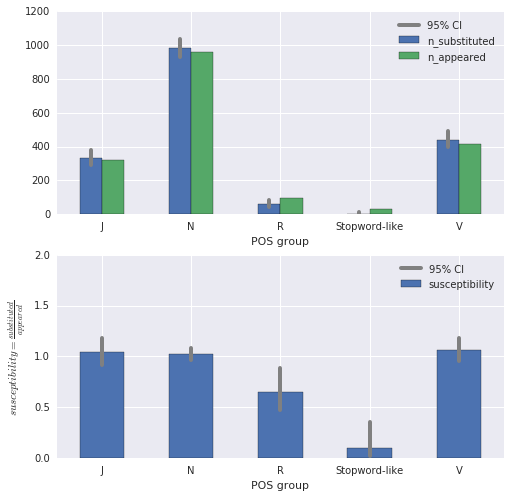

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


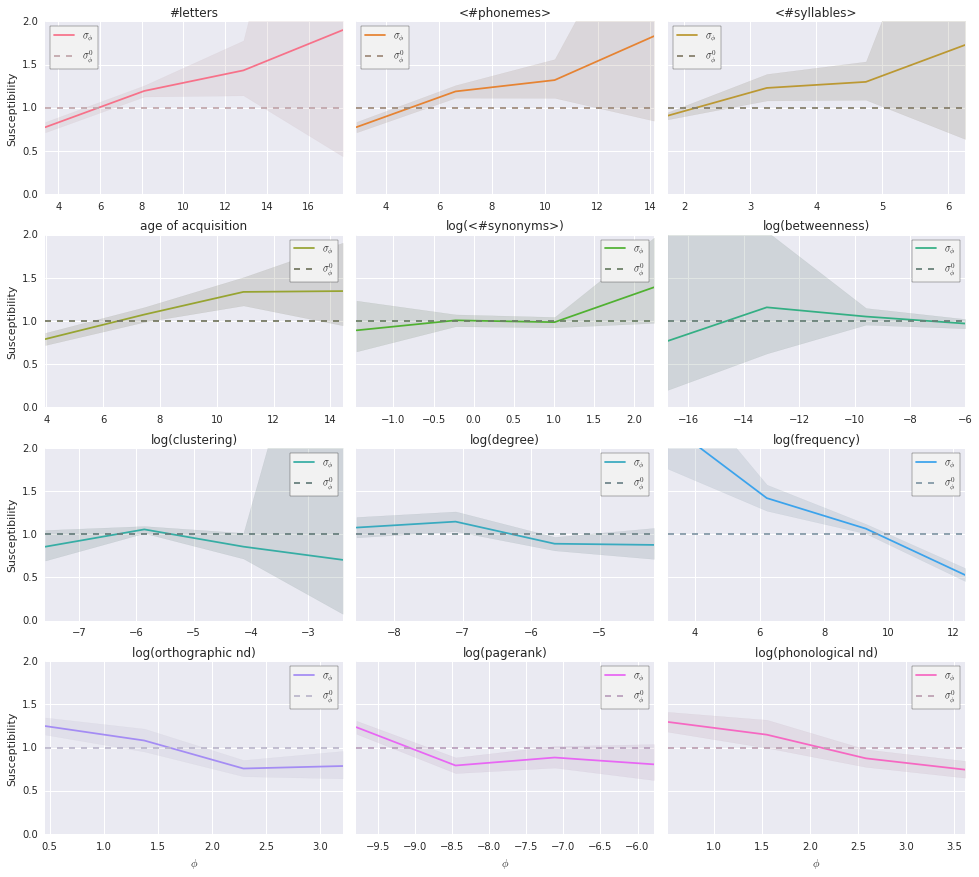

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3, 4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


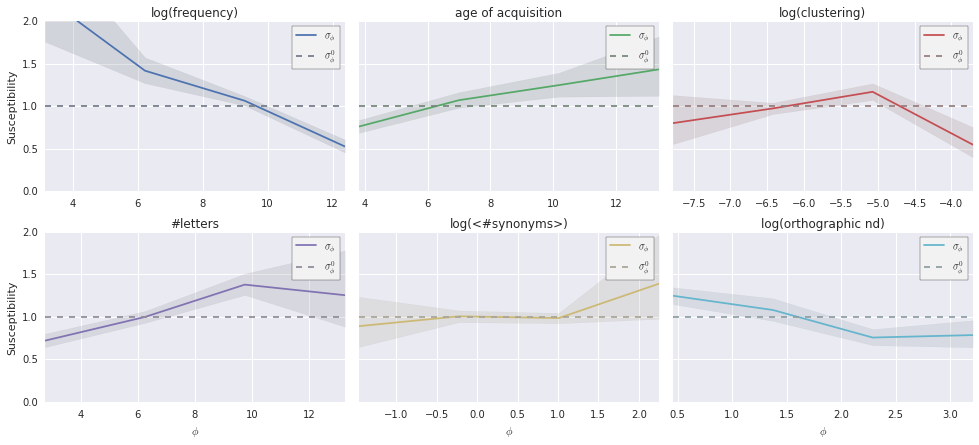

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


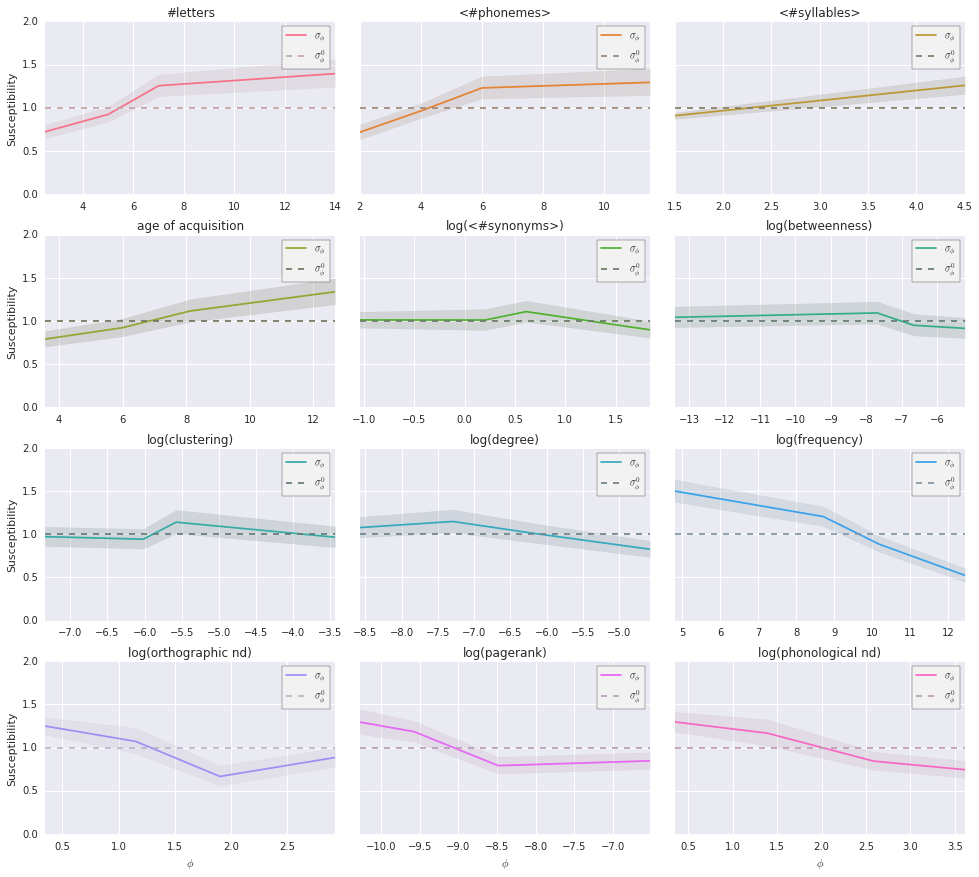

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


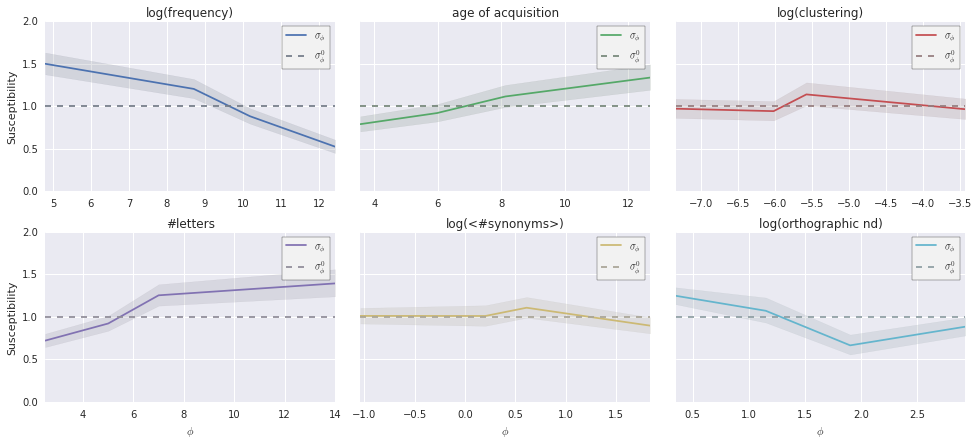

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
     Target NOT different from H_0 (p > 0.001)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


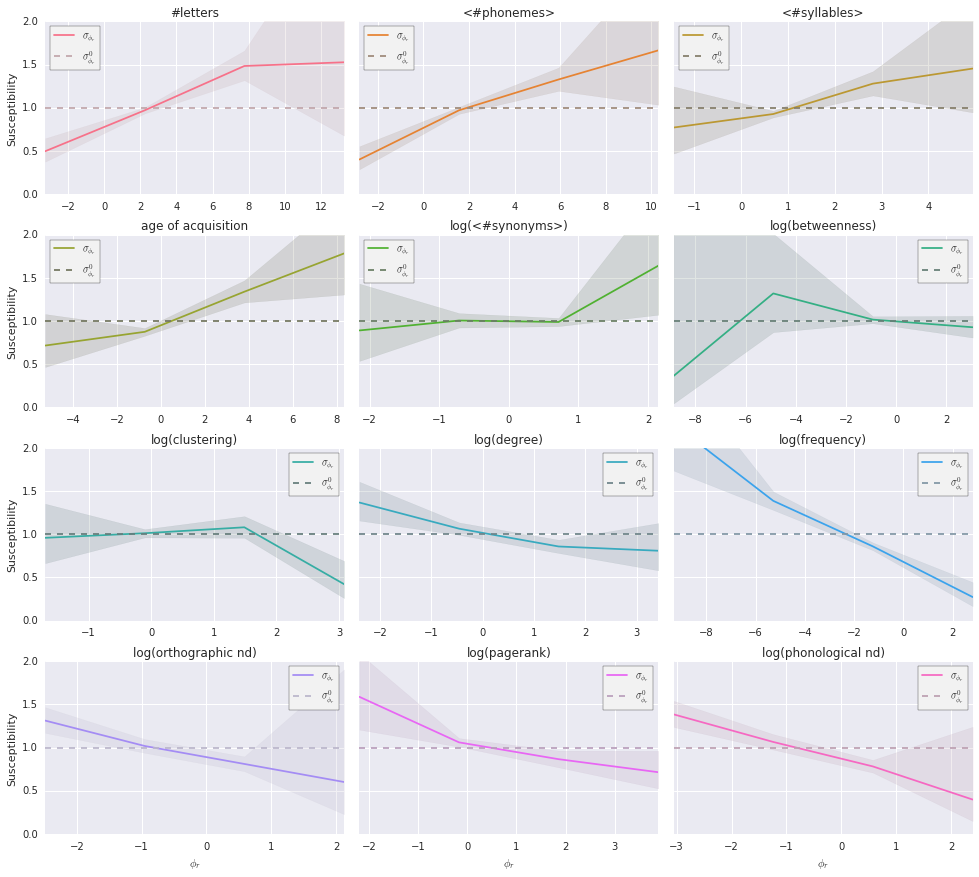

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


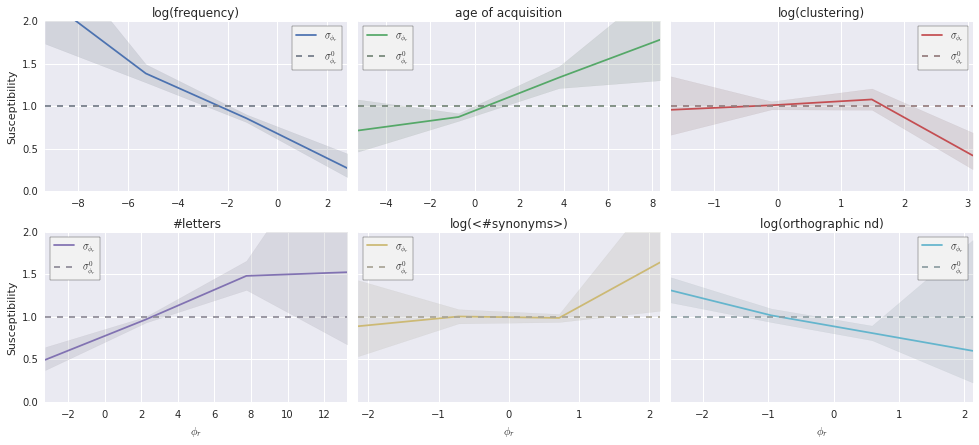

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


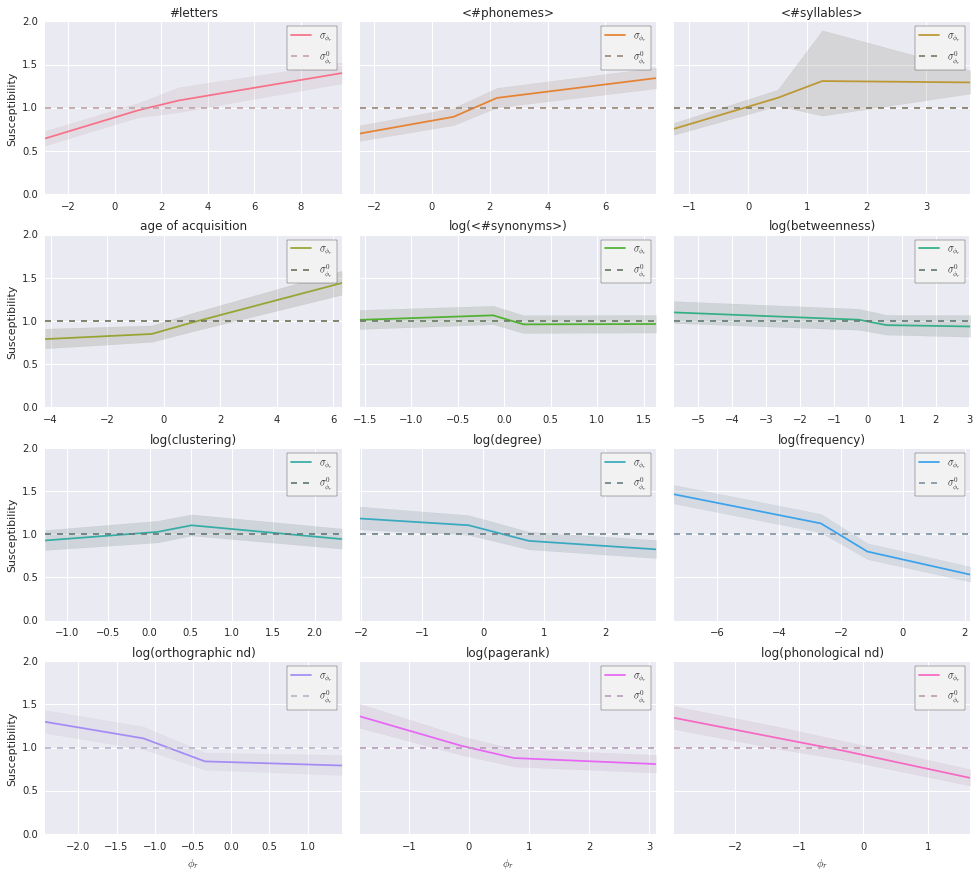

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


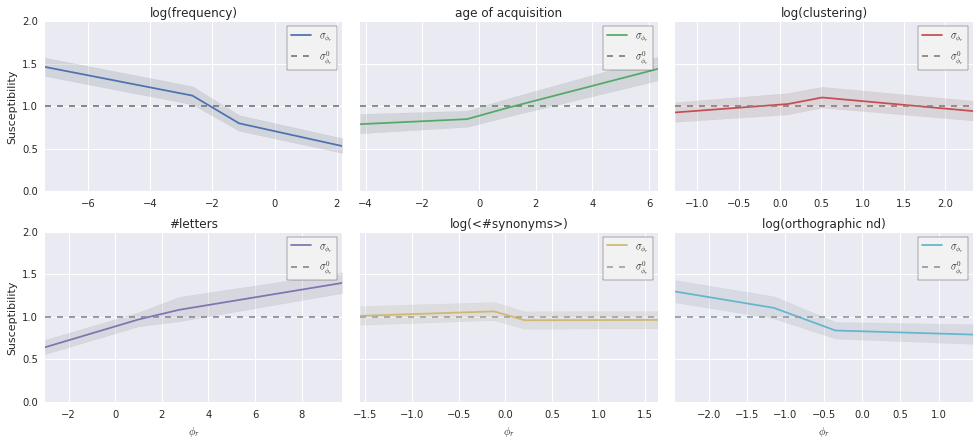

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


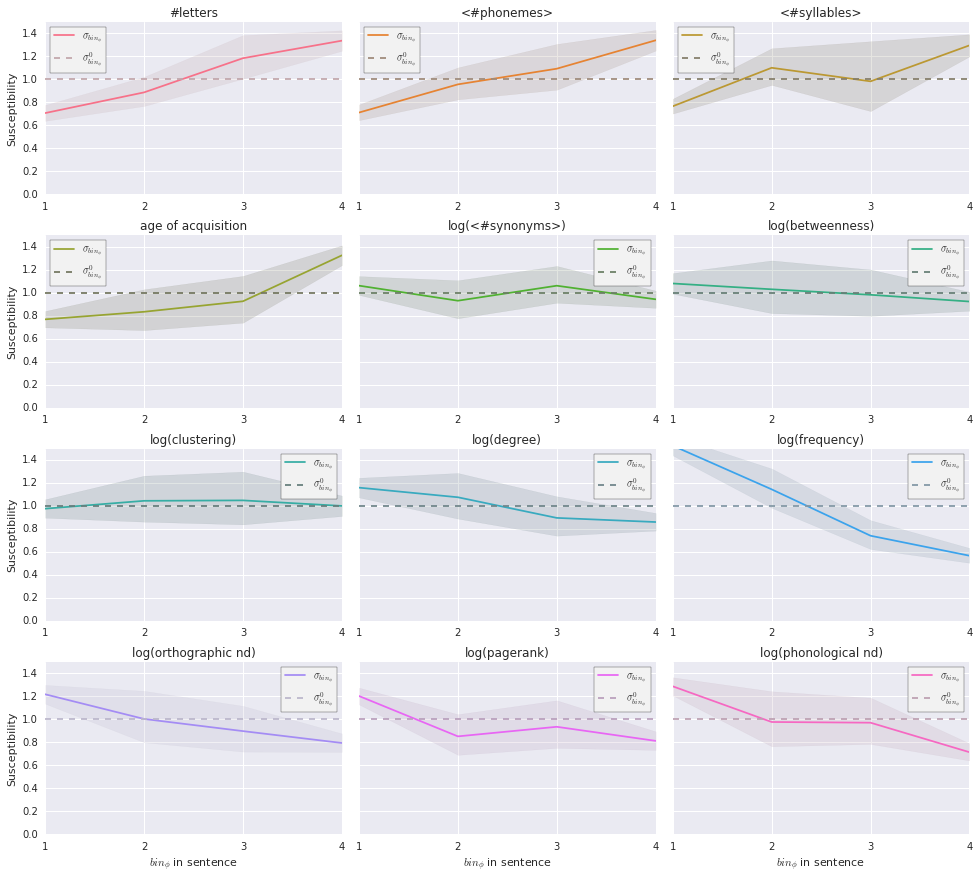

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


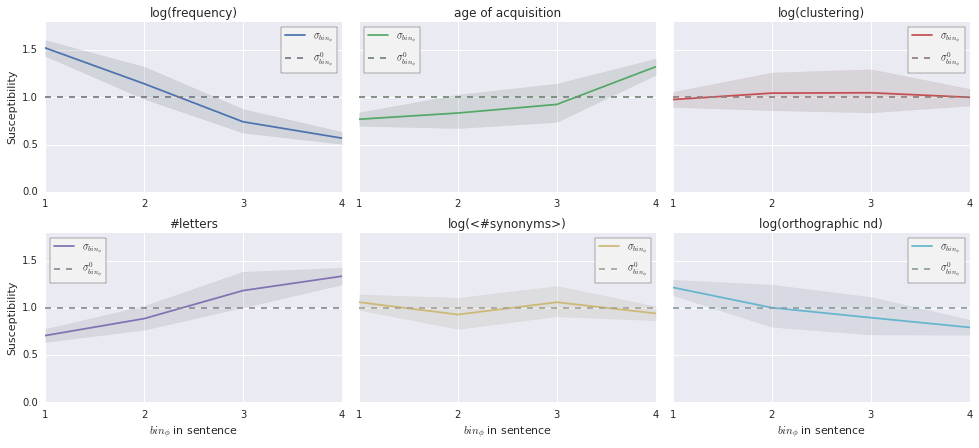

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


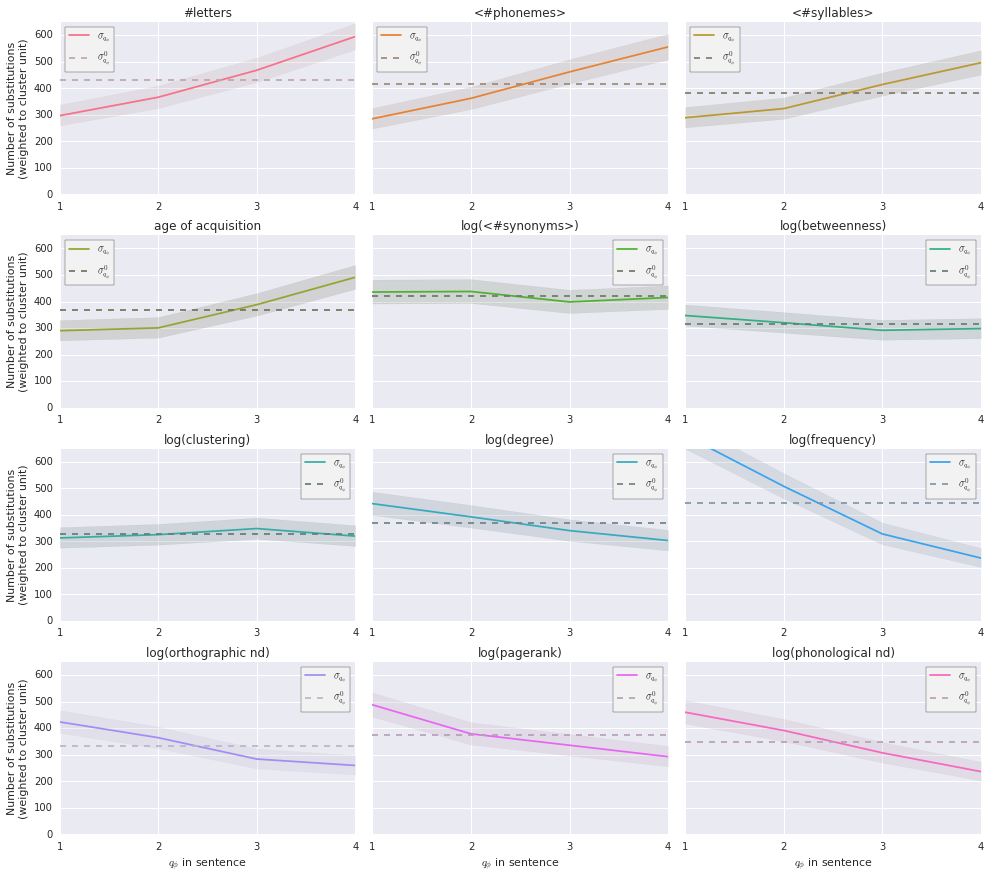

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


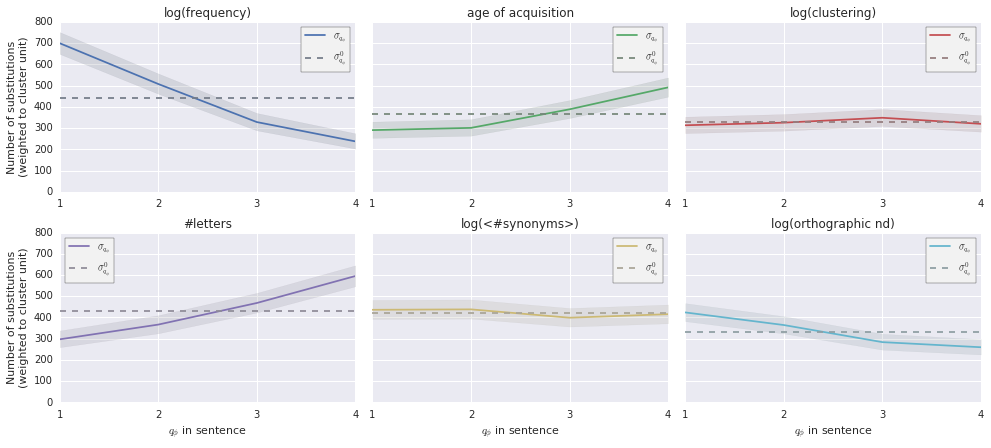

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 114820 word measures (divided into training and prediction sets)


62.21% of words well predicted (non-random at p = 5e-324)
Precision = 0.36
Recall = 0.54

Coefficients:
intercept                                             4.004491
global_frequency                                     -0.413373
global_aoa                                           -0.607352
global_letters_count                                  0.153319
global_orthographic_density                           0.140271
global_frequency * global_aoa                         0.054392
global_frequency * global_letters_count              -0.030225
global_frequency * global_orthographic_density        0.020394
global_aoa * global_letters_count                     0.025008
global_aoa * global_orthographic_density             -0.030878
global_letters_count * global_orthographic_density    0.006215
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 114820 word measures (divided into training and prediction sets)



61.96% of words well predicted (non-random at p = 5e-324)
Precision = 0.35
Recall = 0.50

Coefficients:
intercept                                                        -0.342935
sentence-rel_frequency                                           -0.159536
sentence-rel_aoa                                                 -0.004718
sentence-rel_letters_count                                        0.016230
sentence-rel_orthographic_density                                 0.124592
sentence-rel_frequency * sentence-rel_aoa                         0.021322
sentence-rel_frequency * sentence-rel_letters_count              -0.004863
sentence-rel_frequency * sentence-rel_orthographic_density        0.058662
sentence-rel_aoa * sentence-rel_letters_count                     0.065811
sentence-rel_aoa * sentence-rel_orthographic_density              0.074169
sentence-rel_letters_count * sentence-rel_orthographic_density    0.046055
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 114820 word measures (divided into training and prediction sets)



62.05% of words well predicted (non-random at p = 5e-324)
Precision = 0.36
Recall = 0.54

Coefficients:
intercept                                                         -2.391450
global_frequency                                                   0.231097
global_aoa                                                        -0.605715
global_letters_count                                               1.047403
global_orthographic_density                                        0.882428
sentence-rel_frequency                                            -0.534232
sentence-rel_aoa                                                   0.732003
sentence-rel_letters_count                                        -0.909109
sentence-rel_orthographic_density                                  1.643731
global_frequency * global_aoa                                      0.020366
global_frequency * global_letters_count                           -0.097581
global_frequency * global_orthographic_density             

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 114820 word measures (divided into training and prediction sets)



64.20% of words well predicted (non-random at p = 5e-324)
Precision = 0.37
Recall = 0.48

Coefficients:
intercept                                                       0.242351
bins-global_frequency                                          -0.618943
bins-global_aoa                                                -0.645531
bins-global_letters_count                                       0.736115
bins-global_orthographic_density                               -0.413339
bins-global_frequency * bins-global_aoa                         0.881121
bins-global_frequency * bins-global_letters_count              -0.735059
bins-global_frequency * bins-global_orthographic_density       -0.122987
bins-global_aoa * bins-global_letters_count                     0.022429
bins-global_aoa * bins-global_orthographic_density             -0.717735
bins-global_letters_count * bins-global_orthographic_density    1.117260
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 114820 word measures (divided into training and prediction sets)



41.44% of words well predicted (non-random at p = 5e-324)
Precision = 0.28
Recall = 0.77

Coefficients:
intercept                                                                 3.025197
quantiles-global_frequency                                               -1.963516
quantiles-global_aoa                                                     -0.147782
quantiles-global_letters_count                                            1.957961
quantiles-global_orthographic_density                                    -3.250862
quantiles-global_frequency * quantiles-global_aoa                        -0.106870
quantiles-global_frequency * quantiles-global_letters_count              -0.071603
quantiles-global_frequency * quantiles-global_orthographic_density        1.861972
quantiles-global_aoa * quantiles-global_letters_count                     0.021313
quantiles-global_aoa * quantiles-global_orthographic_density              0.217879
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 114820 word measures (divided into training and prediction sets)



71.03% of words well predicted (non-random at p = 5e-324)
Precision = 0.44
Recall = 0.30

Coefficients:
intercept                                                                   0.739800
bins-sentence-rel_frequency                                                -0.330585
bins-sentence-rel_aoa                                                      -0.471630
bins-sentence-rel_letters_count                                            -0.392226
bins-sentence-rel_orthographic_density                                      0.739800
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.138217
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.110340
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.330585
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.771604
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.471630
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 114820 word measures (divided into training and prediction sets)



53.57% of words well predicted (non-random at p = 9e-66)
Precision = 0.33
Recall = 0.72

Coefficients:
intercept                                                                             0.665478
quantiles-sentence-rel_frequency                                                     -0.243234
quantiles-sentence-rel_aoa                                                           -0.390584
quantiles-sentence-rel_letters_count                                                 -0.236501
quantiles-sentence-rel_orthographic_density                                          -0.268082
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.105807
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.170950
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.107370
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.169469
quantiles-sentence-rel_aoa * quantiles-se

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 114820 word measures (divided into training and prediction sets)



65.08% of words well predicted (non-random at p = 5e-324)
Precision = 0.39
Recall = 0.53

Coefficients:
intercept                                                                 0.056129
in-sentence-bins_frequency                                               -0.343501
in-sentence-bins_aoa                                                     -0.002688
in-sentence-bins_letters_count                                            0.107601
in-sentence-bins_orthographic_density                                     0.121794
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.069321
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.015538
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.043689
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.085975
in-sentence-bins_aoa * in-sentence-bins_orthographic_density              0.071431
in-sentence-bins_letters_count * in-sentence-bins_orthographic_de

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1436 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.68670993  0.18004724]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.380753  0.584887
aoa            0.740697 -0.270733
letters_count  0.553530  0.764599


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1436 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.62993336  0.20195865]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.496154  0.590834
aoa            0.659846 -0.219645
letters_count  0.564300  0.776319
